In [119]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import statsmodels as sm
from matplotlib import pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)


%matplotlib inline

In [120]:
# Load Data
address = 'vaccinations.csv'
vaccines = pd.read_csv(address)
address = 'vaccination_all_tweets.csv'
tweets = pd.read_csv(address)

In [121]:
vaccines['date'] = pd.to_datetime(vaccines['date'])

# Check the type
type(vaccines['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [122]:
# Daily Vaccination
daily = vaccines[['location',  'iso_code',  'daily_vaccinations']]

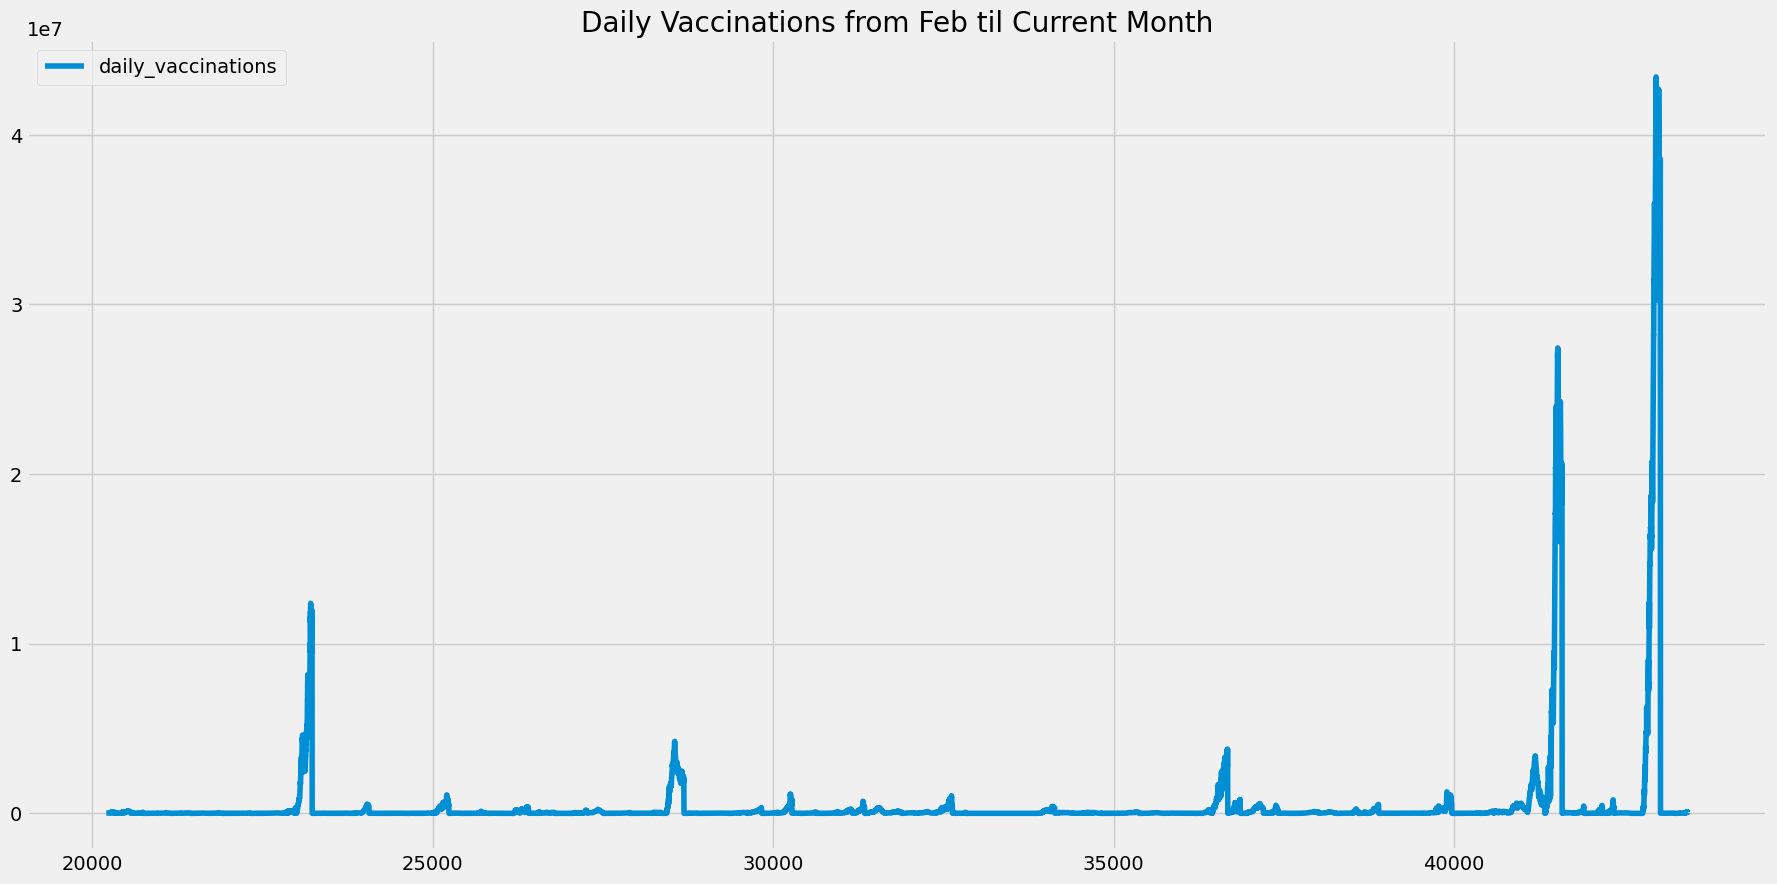

In [123]:
# Plotting data
plt.figure(figsize=(20, 10))
sns.lineplot(data=daily.loc['2021-02-22':])
plt.title('Daily Vaccinations from Feb til Current Month')
plt.show()

In [124]:
tweets['datedt'] = pd.to_datetime(tweets['date'])

In [125]:
tweets['date_only'] = tweets['datedt'].dt.date

In [126]:
tweets_agg_df = tweets.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [127]:
def plot_time_variation(df, x='date_only', y='count', hue=None, size=1, title="", is_log=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x=x, y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    if hue:
        plt.title(f'{y} grouped by {hue} | {title}')
    else:
        plt.title(f'{y} | {title}')
    if(is_log):
        ax.set(yscale="log")
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show() 

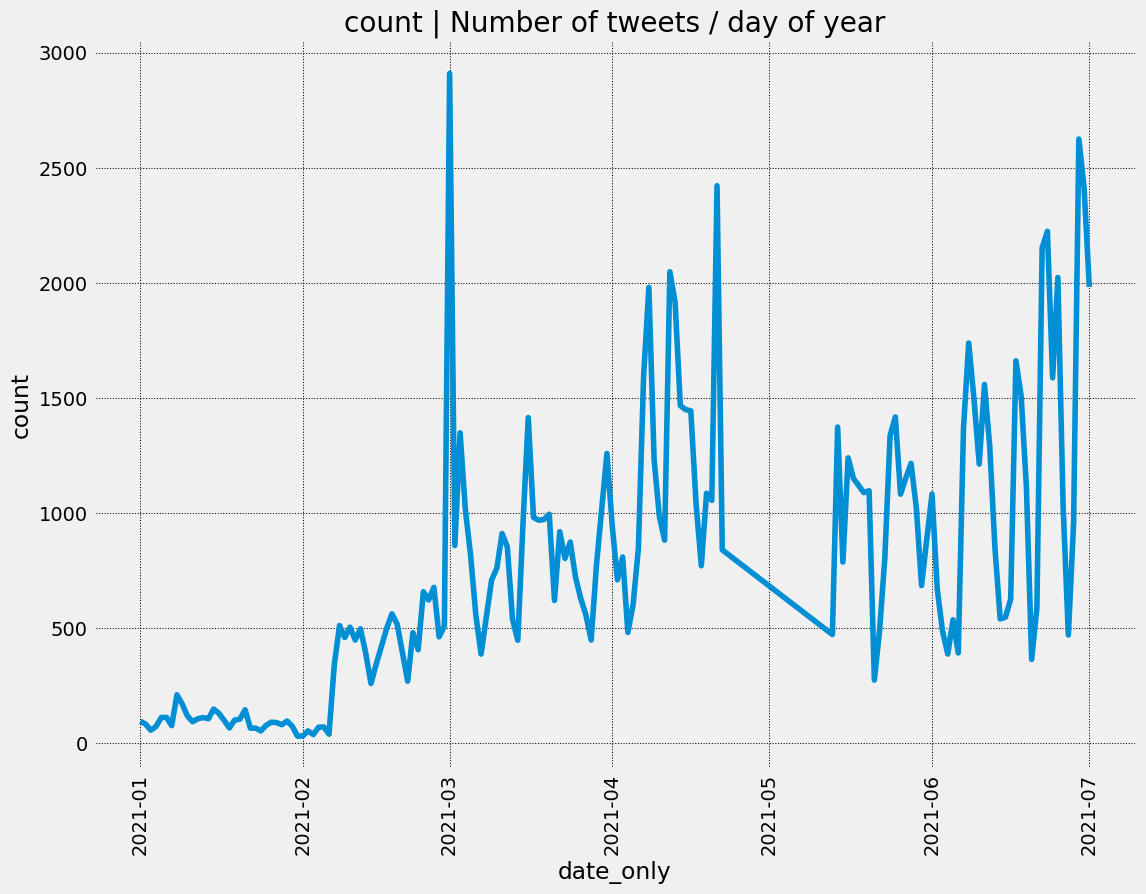

In [160]:
plot_time_variation(tweets_agg_df, title="Number of tweets / day of year",size=3)

In [129]:
tweets['date_only']

0         2020-12-20
1         2020-12-13
2         2020-12-12
3         2020-12-12
4         2020-12-12
             ...    
228202    2021-11-15
228203    2021-11-15
228204    2021-11-15
228205    2021-11-15
228206    2021-11-15
Name: date_only, Length: 228207, dtype: object

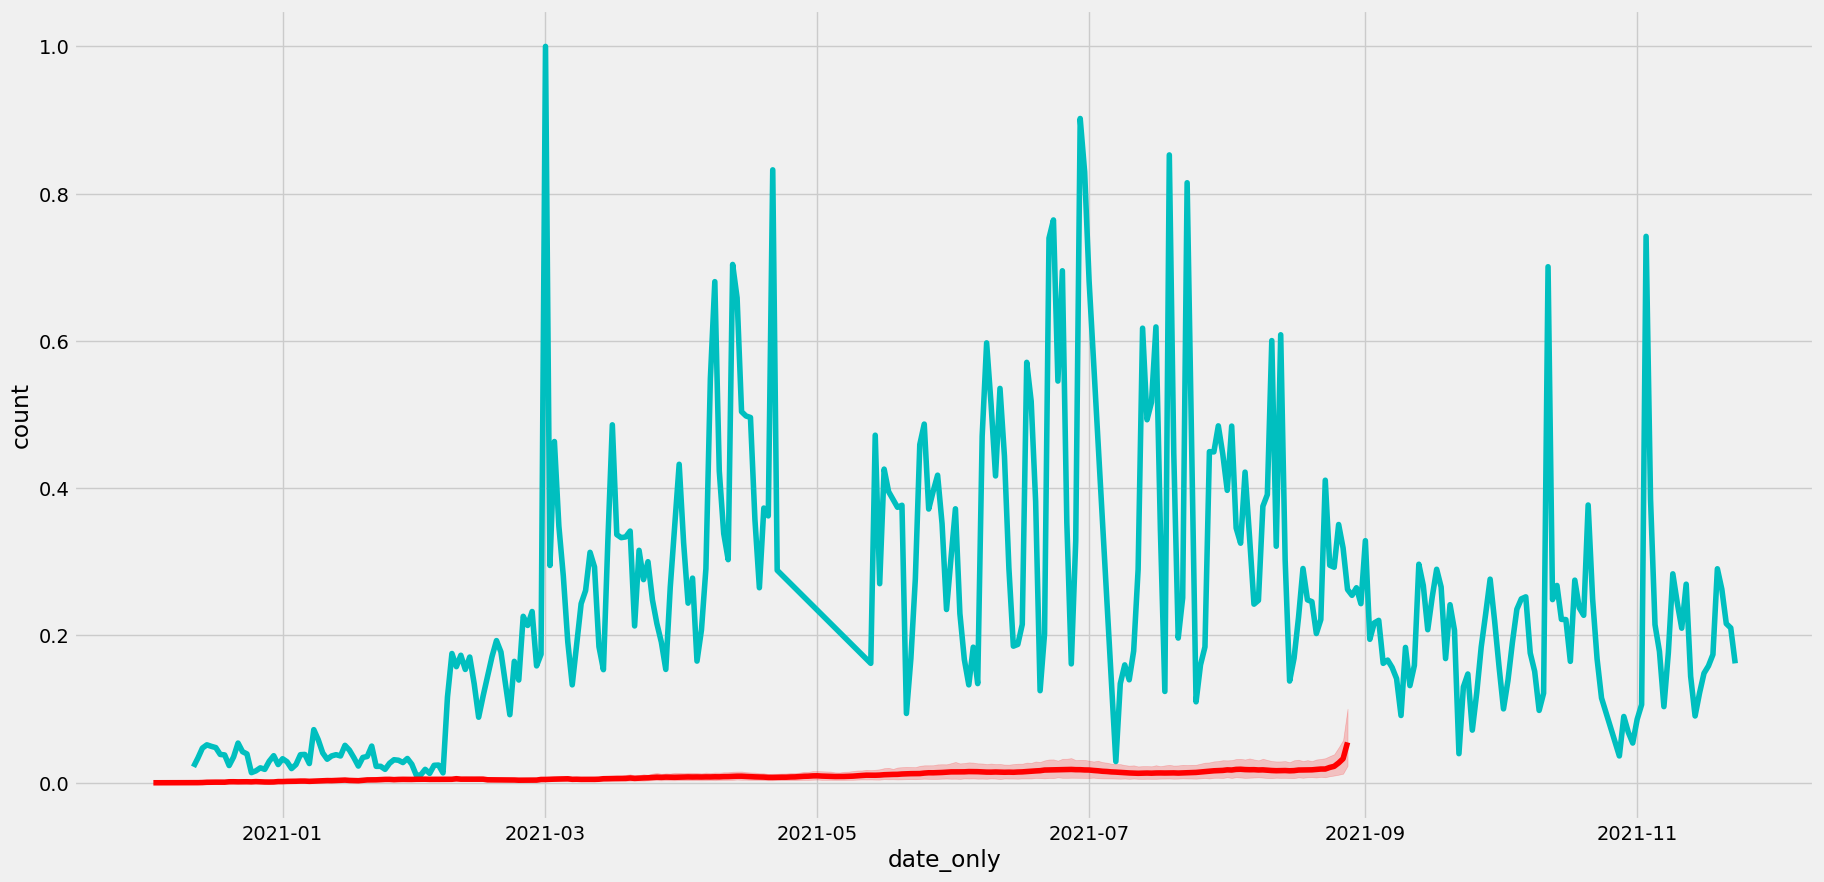

In [130]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=tweets_agg_df['date_only'], y=tweets_agg_df['count']/tweets_agg_df['count'].max(), data=tweets_agg_df, color = 'c')
sns.lineplot(x=vaccines['date'], y=vaccines['daily_vaccinations']/vaccines['daily_vaccinations'].max(), data=vaccines, color = 'r')
plt.show()

### ***Выделим часть соотвествующую примерно половине длины данных о вакцинации (которые сейчас крайне плохо видно)***

In [131]:
tweets_agg_df['date_only']=pd.to_datetime(tweets_agg_df['date_only'])

In [132]:
tweets_agg_df=tweets_agg_df[(tweets_agg_df['date_only'] >= '2021-01-01') & (tweets_agg_df['date_only'] <= '2021-07-01')]

In [133]:
vaccines=vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-07-01')].groupby([vaccines['date'].dt.date]).sum()

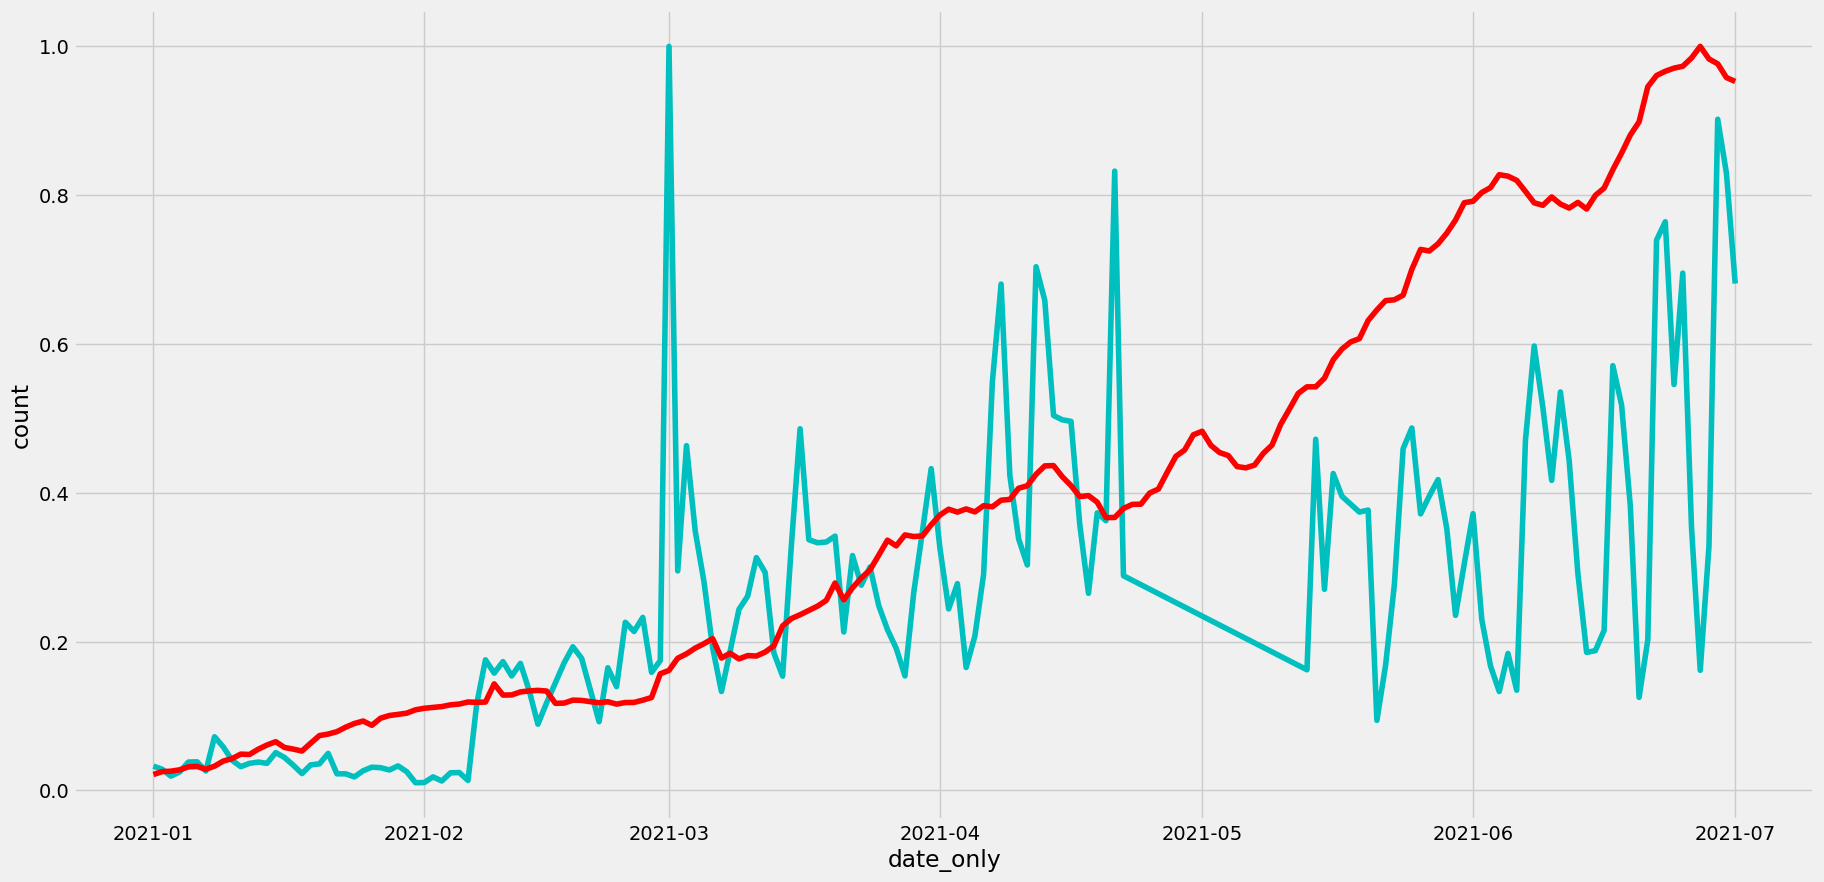

In [134]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=tweets_agg_df['date_only'], y=tweets_agg_df['count']/tweets_agg_df['count'].max(), data=tweets_agg_df['count'], color = 'c')
sns.lineplot(data=vaccines['daily_vaccinations']/vaccines['daily_vaccinations'].max(), color = 'r')
plt.show()

In [135]:
tweets_agg_df = tweets_agg_df.set_index(['date_only'])

In [136]:
tweets_agg_df

,count
date_only,
2021-01-01,95
2021-01-02,83
2021-01-03,56
2021-01-04,72
2021-01-05,111
...,...
2021-06-27,470
2021-06-28,957
2021-06-29,2626


In [137]:
vaccines['daily_vaccinations'][tweets_agg_df.index]

date_only
2021-01-01      3818590.0
2021-01-02      4504894.0
2021-01-03      4613597.0
2021-01-04      4934845.0
2021-01-05      5653379.0
                 ...     
2021-06-27    178349163.0
2021-06-28    175331704.0
2021-06-29    174173353.0
2021-06-30    170874596.0
2021-07-01    169947643.0
Name: daily_vaccinations, Length: 162, dtype: float64

### ***Грейнджер (несколько вариантов)***

### **начальная гипотеза - твиты НЕ являются причиной вакцинации**

In [138]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3620  , p=0.0015  , df_denom=152, df_num=3
ssr based chi2 test:   chi2=16.8267 , p=0.0008  , df=3
likelihood ratio test: chi2=15.9945 , p=0.0011  , df=3
parameter F test:         F=5.3620  , p=0.0015  , df_denom=152, df_num=3


{3: ({'ssr_ftest': (5.361967522719137, 0.0015478932595360385, 152.0, 3),
   'ssr_chi2test': (16.826700712743605, 0.0007671725346067075, 3),
   'lrtest': (15.994549776987697, 0.0011369056381917726, 3),
   'params_ftest': (5.361967522709638, 0.0015478932595548998, 152.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

### **Учитывая F test = 5.3620 (p = 0.0015), твиты могут являться причиной вакцинации**

In [139]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[5])


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0072  , p=0.0810  , df_denom=146, df_num=5
ssr based chi2 test:   chi2=10.7924 , p=0.0557  , df=5
likelihood ratio test: chi2=10.4376 , p=0.0637  , df=5
parameter F test:         F=2.0072  , p=0.0810  , df_denom=146, df_num=5


{5: ({'ssr_ftest': (2.0072411390418954, 0.08095082113586298, 146.0, 5),
   'ssr_chi2test': (10.792358179095123, 0.05565593062189442, 5),
   'lrtest': (10.437587085240011, 0.06374439307778597, 5),
   'params_ftest': (2.007241139155362, 0.08095082111960245, 146.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

### **Учитывая F test = 2.0072 (p = 0.0810), твиты НЕ могут являться причиной вакцинации**

In [140]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([tweets_agg_df['count'], vaccines['daily_vaccinations'][tweets_agg_df.index]]).transpose(), maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2888  , p=0.2432  , df_denom=131, df_num=10
ssr based chi2 test:   chi2=14.9540 , p=0.1337  , df=10
likelihood ratio test: chi2=14.2634 , p=0.1613  , df=10
parameter F test:         F=1.2888  , p=0.2432  , df_denom=131, df_num=10


{10: ({'ssr_ftest': (1.288799798589947, 0.24316470056672373, 131.0, 10),
   'ssr_chi2test': (14.954012930203968, 0.13374747890256367, 10),
   'lrtest': (14.26335805994313, 0.16131439310813198, 10),
   'params_ftest': (1.2887997985434558, 0.24316470059269354, 131.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

### **Учитывая F test = 1.2888 (p = 0.2432), твиты НЕ могут являться причиной вакцинации**

### ***Обратный Грейнджер***

### **начальная гипотеза - вакцинация НЕ является причиной твитов**

In [141]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2078  , p=0.0005  , df_denom=152, df_num=3
ssr based chi2 test:   chi2=19.4812 , p=0.0002  , df=3
likelihood ratio test: chi2=18.3770 , p=0.0004  , df=3
parameter F test:         F=6.2078  , p=0.0005  , df_denom=152, df_num=3


{3: ({'ssr_ftest': (6.207835622989816, 0.000525523154217992, 152.0, 3),
   'ssr_chi2test': (19.481168369514094, 0.00021739582749448784, 3),
   'lrtest': (18.377044162466518, 0.00036770836106582905, 3),
   'params_ftest': (6.207835622989838, 0.0005255231542179765, 152.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

### **Учитывая F test = 6.2078 (p = 0.0005), вакцинация может являться причиной твитов**

In [142]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[5])


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8646  , p=0.0026  , df_denom=146, df_num=5
ssr based chi2 test:   chi2=20.7789 , p=0.0009  , df=5
likelihood ratio test: chi2=19.5143 , p=0.0015  , df=5
parameter F test:         F=3.8646  , p=0.0026  , df_denom=146, df_num=5


{5: ({'ssr_ftest': (3.8646191601769173, 0.0025590911913524576, 146.0, 5),
   'ssr_chi2test': (20.778945484512878, 0.0008917643335385307, 5),
   'lrtest': (19.514329737929074, 0.001540972785558278, 5),
   'params_ftest': (3.86461916017698, 0.002559091191352113, 146.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

### **Учитывая F test = 3.8646 (p = 0.0026), вакцинация может являться причиной твитов**

In [143]:
grangercausalitytests(pd.DataFrame([vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count']]).transpose(), maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4900  , p=0.0004  , df_denom=131, df_num=10
ssr based chi2 test:   chi2=40.4949 , p=0.0000  , df=10
likelihood ratio test: chi2=35.9007 , p=0.0001  , df=10
parameter F test:         F=3.4900  , p=0.0004  , df_denom=131, df_num=10


{10: ({'ssr_ftest': (3.490016818340378, 0.00042253622489294264, 131.0, 10),
   'ssr_chi2test': (40.49485163265171, 1.386049989084577e-05, 10),
   'lrtest': (35.90071093928691, 8.754787503340689e-05, 10),
   'params_ftest': (3.490016818341006, 0.00042253622489211366, 131.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

### **Учитывая F test = 3.4900 (p = 0.0004), вакцинация может являться причиной твитов**

### **Итого пять очень-очень логичных результатов**

### ***Стационарность?***

count    1.820000e+02
mean     6.861788e+07
std      5.137927e+07
min      3.818590e+06
25%      2.126531e+07
50%      6.541543e+07
75%      1.051543e+08
max      1.783492e+08
Name: daily_vaccinations, dtype: float64

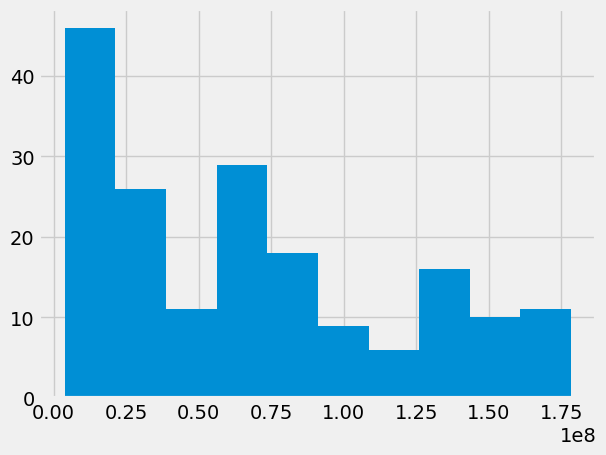

In [144]:
itog = vaccines['daily_vaccinations'].describe()
vaccines['daily_vaccinations'].hist()

itog

In [145]:
print('V = %f' % (itog['std']/itog['mean']))

V = 0.748774


### **Неоднородный ряд, но сойдёт, разброс небольшой**

### ***тест Дикки-Фуллера (5% уверенности)***

In [151]:
test = sm.tsa.stattools.adfuller(vaccines['daily_vaccinations'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд вакцинаций не стационарен')
else:
    print('единичных корней нет, ряд вакцинаций стационарен')

adf:  1.6461773856200546
p-value:  0.9979897071693794
Critical values:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
есть единичные корни, ряд вакцинаций не стационарен


### ***Ряд вакцинаций не стационарен***

In [154]:
test = sm.tsa.stattools.adfuller(tweets_agg_df['count'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд с твитами не стационарен')
else:
    print('единичных корней нет, ряд с твитами стационарен')

adf:  -1.2794662070048408
p-value:  0.6385134141755677
Critical values:  {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
есть единичные корни, ряд с твитами не стационарен


### ***Ряд твитов не стационарен***

### ***Тогда проверяем коинтегрированность***

In [156]:
from statsmodels.tsa.stattools import coint
alf = 0.05

score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=3)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < alf else "NOT cointegrated")

cointegration: score: -1.96
cointegration: p-value: 0.5483097032
NOT cointegrated


In [157]:
score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=5)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < alf else "NOT cointegrated")

cointegration: score: -1.08
cointegration: p-value: 0.8874172779
NOT cointegrated


In [158]:
score, pvalue, _ = coint(vaccines['daily_vaccinations'][tweets_agg_df.index], tweets_agg_df['count'], maxlag=10)
pvalue

print(f'cointegration: score: {score:.2f}')
print(f'cointegration: p-value: {pvalue:.10f}')
print("cointegrated - there MUST be Granger causality" if pvalue < alf else "NOT cointegrated")

cointegration: score: -0.80
cointegration: p-value: 0.9351817441
NOT cointegrated


### **Жизнь - боль, стационарной линейной комбинации (коинтеграции) нет**